# TextRank + ROUGE

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
pd.set_option('display.max_colwidth', -1)
from collections.abc import Iterable
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import os
import gensim.downloader as api
from pymystem3 import Mystem
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from rouge import Rouge
import re
from tqdm import tqdm_notebook
import time
import os.path
import pixiedust


### Build dataset

In [38]:
dtypes_br = {
    'match_id': 'int64',
    'team1': 'object',
    'team2': 'object',
    'name': 'object',
    'match_time': 'int64',
    'type': 'category',
    'minute': 'int64',
    'content': 'object',
    'message_time':'int64'
}
broadcasts = pd.read_csv('data/ods_broadcasts_201905301157.csv',
                 header=0, 
                 usecols=dtypes_br.keys(), 
                 skipinitialspace=True,
                 skip_blank_lines=True,
                 encoding='utf-8')
dtypes_ns = {
    'id': 'int64',
    'name': 'object',
    'ctime': 'int64',
    'body': 'object',
    'match_id': 'int64',
}
news = pd.read_csv('data/ods_match_news.csv',
                 header=0, 
                 usecols=dtypes_ns.keys(), 
                 skipinitialspace=True,
                 skip_blank_lines=True,
                 encoding='utf-8')

### Prepare dataset

Split by sentences, word2vec embedding,

In [39]:
type(broadcasts[broadcasts['match_id']==18936]['content'])

pandas.core.series.Series

### Vectorising texts

#### word2vec+ruscorpora-300

In [40]:
def tag(word, model):
    try:
        assert type(word) == str
        if len(word) < 2:
            #print("Warning in: ", word, 'len: ', len(word))
            return None
        processed = None
        processed = model.analyze(word)[0]
        lemma = processed["analysis"][0]["lex"].lower().strip()
        pos = processed["analysis"][0]["gr"].split(',')[0]
        pos = pos.split('=')[0].strip()
        _MAPPINGS = {
                    'A': 'ADJ',
                    'A-PRO': 'PRON',
                    'APRO': 'PRON',
                    'ADV': 'ADV',
                    'ADV-PRO': 'PRON',
                    'ADVPRO': 'PRON',
                    'ANUM': 'ADJ',
                    'CONJ': 'CONJ',
                    'INTJ': 'X',
                    'NONLEX': '.',
                    'NUM': 'NUM',
                    'PARENTH': 'PRT',
                    'PART': 'PRT',
                    'PR': 'ADP',
                    'PRAEDIC': 'PRT',
                    'PRAEDIC-PRO': 'PRON',
                    'S': 'NOUN',
                    'S-PRO': 'PRON',
                    'SPRO': 'PRON',
                    'V': 'VERB',
                }
        tagged = lemma+'_'+_MAPPINGS[pos]
    except: 
        #print("Error in: ", word, 'len: ', len(word), 'processed: ', processed)
        return None
    return tagged

In [41]:
def tag_dummy(word, model):
    return word

In [73]:
def content_to_vectors(sentences, model_embd, method_tag, model_tag):
    assert type(sentences) == list
    size=len(sentences) 
    vector_sentences = np.zeros((size, 300))
    for i in range(size):
        sentence = sentences[i]
        words = sentence.lower().replace('"','').split(" ")
        vector_sentence = np.array([model_embd[method_tag(word, model_tag)] for word in words if method_tag(word, model_tag) in model_embd.vocab])
        if vector_sentence.size == 0:
            print("Warning: sentence.size euqal zero")
            continue
        vector_sentences[i] = np.sum(vector_sentence, axis=0)/vector_sentence.shape[0]
    return vector_sentences

### Building similarity matrix

In [43]:
def build_similarity(vs, method=cosine_similarity):
    return method(vs,vs)

### Building graph and compute textrank

In [50]:
def get_most_ranked(sim_mat, sentences, n=10):
    assert type(sentences) == list
    assert n < len(sentences)
    result = []
    nx_graph = nx.from_numpy_array(sim_mat)
    try:
        scores = nx.pagerank(nx_graph)
    except nx.PowerIterationFailedConvergence:
        print("Warning: raised PowerIterationFailedConvergence")
        scores = nx.pagerank(nx_graph, max_iter=1000, tol=1e-01)
    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
    for sentense in ranked_sentences[0:n]:
        result.append(sentense[1])
    return " ".join(result)

### Compare system and "gold" summaries using ROUGE

In [45]:
def clean_news_text(text):
    return  re.sub("\n","",re.sub("(&#(?:\d)*;)", "", re.sub("<.*?>", "", text))).replace("\x96","")

In [46]:
def compare(news, broadcasts, model_embd, tag, model_tag, similarity):
    all_scores = []

    for match_id in tqdm_notebook(news.match_id.unique()):
        try:
            cur_broadcasts = list(broadcasts[broadcasts['match_id']==match_id]['content'])
            v = content_to_vectors(cur_broadcasts, model_embd=model_embd, tag=tag, model_tag=model_tag)
            sim_mat = build_similarity(v)
            try:
                hyps = get_most_ranked(sim_mat, cur_broadcasts, 10)
            except AssertionError:
                pass
            hyps = clean_news_text(hyps)
            for cur_news in news[news.match_id==match_id].body:
                cur_news = clean_news_text(cur_news)
                r = similarity.get_scores(hyps, cur_news)
                all_scores.append(r[0]['rouge-1']['f'])
        except Exception as e:
            print(e)
            pass

    return all_scores

#### Compare embadding: word2vec+ruscorpora-300, type: all_news vs hyps, similarity: rouge-1

In [47]:
if not os.path.exists('data/all_scores_w2v_ruscorpora_300.npy'):
    evaluator = Rouge()
    model_mystem = Mystem()
    model_w2w_ruscorpora_300 = api.load("word2vec-ruscorpora-300")

    all_scores = compare(news, broadcasts, model_w2w_ruscorpora_300, tag, model_mystem, evaluator)
    
    np.save('data/all_scores_w2v_ruscorpora_300',all_scores)
else:
    all_scores = np.load('data/all_scores_w2v_ruscorpora_300.npy')
    

Text(0.5, 0, 'ROUGE-1 (f1)scores')

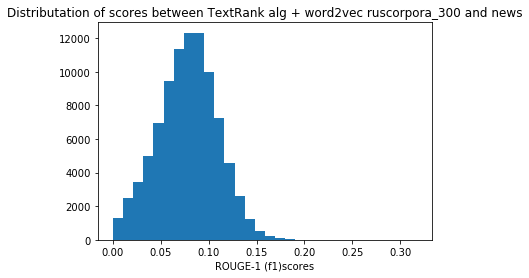

In [48]:
plt.hist(all_scores, bins=30)
plt.title("Distributation of scores between TextRank alg + word2vec ruscorpora_300 and news")
plt.xlabel("ROUGE-1 (f1)scores")

#### Compare embadding: fasttext+taiga, type: all_news vs hyps, similarity: rouge-1

In [54]:
#%%pixie_debugger

if not os.path.exists('data/all_scores_ft_taiga_300.npy'):
    evaluator = Rouge()
    model_tag = None
    model_fast_taiga = KeyedVectors.load("data/187/model.model")

    all_scores = compare(news, broadcasts, model_fast_taiga, tag_dummy, model_tag, evaluator)
    
    np.save('data/all_scores_ft_taiga_300',all_scores)
else:
    all_scores = np.load('data/all_scores_ft_taiga_300.npy')
    

Text(0.5, 0, 'ROUGE-1 (f1)scores')

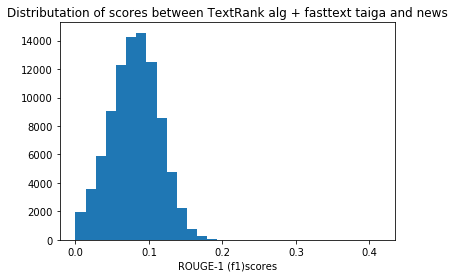

In [55]:
plt.hist(all_scores, bins=30)
plt.title("Distributation of scores between TextRank alg + fasttext taiga and news")
plt.xlabel("ROUGE-1 (f1)scores")

### Review hyps summary

In [88]:
def show_hyps_summary(broadcasts, match_id, model_embd, method_tag, model_tag):
    cur_broadcasts = list(broadcasts[broadcasts['match_id']==match_id]['content'])
    v = content_to_vectors(cur_broadcasts, model_embd=model_embd, method_tag=method_tag, model_tag=model_tag)
    sim_mat = build_similarity(v)
    hyps = get_most_ranked(sim_mat, cur_broadcasts, 10)
    return clean_news_text(hyps)

In [65]:
news.match_id.unique()[0:50]

array([18936, 18935, 18941, 18956, 18957, 19236, 19222, 19227, 18925,
       19104, 19105, 19235, 19231, 19108, 19107, 19109, 19113, 19111,
       19114, 19112, 19115, 19116, 19117, 19122, 19120, 19119, 19121,
       19644, 19647, 19123, 19125, 19124, 19126, 19127, 19129, 19128,
       19130, 19654, 19653, 19132, 19131, 19133, 19134, 19137, 19135,
       19136, 19138, 19675, 19142, 19139])

#### Word2vec

In [81]:
model_tag_mystem = Mystem()
model_embd_w2v = api.load("word2vec-ruscorpora-300")
model_tag_dummy = None
model_embd_ft = KeyedVectors.load("data/187/model.model")

In [105]:
for match_id in [18936,19131,19654,19139,18925]:
    print("="*45,"Raw text: match_id:%s"%str(match_id),"="*45)
    print(clean_news_text(" ".join(list(broadcasts[broadcasts['match_id']==18936]['content'])))) 
    print("="*50,'Word2vec',"="*50)
    print(show_hyps_summary(broadcasts, match_id, model_embd_w2v, tag, model_tag_mystem))
    print("="*50,'FastText',"="*50)
    print(show_hyps_summary(broadcasts, match_id, model_embd_ft, tag_dummy, model_tag_dummy))
    print("="*100)

============================================= Raw text: match_id:18936 =============================================
Интересный парадокс жребия - армейцам, единственному клубу, выигравшему все свои матчи в групповом турнире, достался едва ли не самый сложный соперник из всех возможных! Думается, что одним из показателей роста нашего футбола является то обстоятельство, что мало кто из специалистов, болельщиков или самих футболистов говорит о разнице в игровом тонусе команд. Очень мотивированным должен предстать перед футбольной Европой Вагнер Лав, возглавляющий с 8 мячами список лучших бомбардиров нынешнего Кубка УЕФА.  Вагнер часто обижался в открытой прессе на то, что наставник сборной Бразилии Дунга не вызывает его в сборную, но, продолжи он свои голеадорские  подвиги конца прошлого года, и можно быть уверенным, что вызов в первую команду ему обеспечен (сами понимаете, какая конкуренция на место нападающего в сборной Бразилии).  Отметим, что эксперты официального сайта УЕФА включили 

Очень точно заметил Юрий Жирков о том, что футболистам ЦСКА было абсолютно все равно, с кем играть, ведь если ставить самые высокие цели, то надо быть готовыми попасть на третью команду английской премьер-лиги (текущее место) уже на стадии 1/16 финала.   Эшли Янг ворвался в штрафную площадь, упал, надеясь на пенальти, но главный арбитр занял правильную позицию и показывает, что игроку "Астон Виллы" нужно подниматься. Вагнер в центре поля куражится с мячом, сумел бразилец разогнать атаку, заметить подключение Жиркова по левому флангу, и отдать тому передачу, Юрий пробил в касание в ближний угол, но мяч пошел чуть выше перекладины. Алдонин пробил издали довольно сильно, голкипер "Астон Виллы" не без труда справился с этим ударом, зафиксировав мяч не с первого раза. Блестящая комбинация! Вагнер пяткой отдал мяч на Дзагоева, тот вывел Алексея Березуцкого почти один на один по центру, но защитник пробил очень плохо, направив мяч много правее штанги! Жирков выбил мяч подальше, Вагнер зацепил

Вячеслав Грозный накануне матча сожалел, что игра со "Спартаком" нагрянула именно сейчас. Мало того, что зажатая в угол команда вполне способна на что-нибудь этакое, так еще на нее направлены все прожекторы общественного внимания. Это неудивительно. О красно-белых говорили бы, даже если бы они играли во второй лиге.   Некоторые цифры первой половины действительно впечатляют. Например, "Спартак" владел мячом 72 процента игрового времени. А "Терек" ни разу не попал в створ ворот Джанаева.  МОМЕНТ! Иван Саенко первый на мяче, который прилетел с фланга. Дикань только с помощью ноги спасает гостей от быстрого гола.  Вячеслав Грозный в интервью "НТВ-Плюс" заявил, что на итоговый результат серьезно повлияло удаление и незасчитанный мяч "Терека". По мнению тренера, судьи очень уж часто не фиксируют голы грозненцев в ворота московских команд.  Гости дважды бьют спартаковцев, прерывая быструю контратаку. УДАЛЕНИЕ. За фол последней надежды из раздевалки матч досмотрит Мищенко.  Кариока здорово "р

Оборону "Динамо" можно было неделю назад похвалить за холодную голову, которая не позволяла разгореться множеству голевых моментов. А вот спокойствие атаки опасно граничило со стадией пассивности. Накануне игры об этом, кстати, говорил Юрий Семин. По словам тренера, сегодняшний полный стадион поможет побороть это скверное обстоятельство.  Поль ле Гуэн, главный тренер гостей, не скрывает, что радары его команды по большей части направлены на внутренний чемпионат, где теоретически ПСЖ имеет возможность самовыдвижения на трон. И шестое место парижан не должно Вас путать. До "Марсела", возглавляющего пелетон, всего лишь четыре очка.  В первом тайме почти все удары "Динамо" в створ обратились голами - два из трех. Интересно, входит ли в это количество результативная подкрутка Ландро? По общему количеству попыток пробить по воротам у нас равенство - 8:8. Владение мячом - 47 на 53.    За неимением собственных еврокубковых делегатов переключаемся на соседей, - тем более к ним непосредственное 

В стартовом составе "Зенита" есть одна большая неожиданность. В запасе останется Анатолий Тимощук, вместо которого появится Игорь Семшов. Дик Адвокат учит играть команду без всемогущего "выжигателя".  Так вышло, что "Зениту" дважды подряд пришлось решать задачу по выкуриванию десяти обороняющихся игроков из штрафной площади соперника. Оба - безуспешно, иначе быть питерцам на вершине.  Два очка из шести возможных и минус 500 тысяч из клубной кассы - таковыми выдались для "Зенита" прошедшие две недели. Задача уберечься от горячей петербуржской руки стоит перед "Химками". Российская премьер-лига, 6 тур, стадион "Петровский". День добрый!  "Химки" сейчас не пересекают центральную линию. К тому же они вообще достаточно редко работают с мячом. Третий гол - вопрос ближайшего времени.  Данниии дотащил атаку "Зенита" до линии штрафной, а затем отдал пас на Зырянова. Защитник гостей невольно блокировал мяч.  Матч выдался вполне смотрибельным. Шесть мячей за игру у нас забивают по праздникам. "Зе

 Стартовые составы пока неизвестны. Я же назову имена тех, кого мы сегодня точно не увидим на поле. За прошлогодние "заслуги" дисквалификацию отбывают у хозяев - Кочиш, а у гостей - Киракосян и Максимов. Также Константин Сарсания, дебютирующий в качестве главного тренера клуба премьер-лиги, вряд ли внесет в заявку травмированного Самсонова.   Зимой подмосковный клуб едва не исчез с футбольной карты, но затем минимальный прожиточный минимум клуба премьер-лиги все-таки удалось отыскать. Чуть позже радость сменилась опасением, что "Химки" могут оказаться попросту неконкурентоспособными. Ожидание старта сопровождалось противоречивыми чувствами.  Одемвинги не смог укротить мяч, выходя на рандеву с Березовским. А чуть ранее "Локомотив" плохо разыграл штрафной удар.  Что ж, сегодняшних соперников можно назвать одними из самых загадочных команд сезона. Но загадочность проявляетя в них совершенно по-разному. Если болельщики хозяев верят, что кризисные времена ушли в прошлое, и команда в этом го